## Umair Chaanda
### Kaggle competition

# Predict Traffic Flow Volume Using Time Series Analysis

## Neural Networks and Deep Learning

# 1. Goal

One of the most common applications of Time Series models is to predict future values. The goal of this project is to apply deep learning to do time series forecasting. In particular, create deep learning models to predict future traffic volume at a location in Minnesota, between Minneapolis and St Paul.

The specific goal will be to predict from a 6-hour input window, just the traffic volume for 2 hours past the end of the window.

To achieve this goal, TensorFlow (& Keras) are used to create and train Recurrent Neural Networks (RNNs) running various model configurations and hyperparameter values to empirically examine their effects in learning. 

To search for an optimal model/hyperparameter setting for RNN, let's experiment with several different models and try exploring advanced features and architectures such as:

- Batch size
- Number of recurrent units
- Stacking recurrent layers
- Recurrent dropout
- Bidirectional RNNs
- Number of epochs

Finaly, we will submit our experimentations predictions for test dataset to Kaggle competition to compete with other students. 

# 2. Import Packages

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

import tensorflow.keras as keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from tensorflow.keras.layers import *
from tensorflow.keras import regularizers
from tensorflow.keras import datasets, layers, models

print(tf.__version__)

2.4.1


In [2]:
import warnings
warnings.filterwarnings('ignore')

The project involves the use of Python scripts in Jupyter Notebook to perform various data analysis or mining tasks including available modules or libraries such as:

- **NumPy**: 			For carrying out efficient computations.
- **Pandas**: 			For reading and writing spreadsheets.
- **Matplotlib**: 		For displaying plots.
- **Seaborn**: 			For visualization of data.
- **TensorFlow**:		For deep neural networks
- **Keras**:			Python interface for artificial neural networks

# 3. Exploratory Data Analysis (EDA)

## 3.1 Data Description:
The data used in this project is metro interstate traffic volume data. It is publicly-available and acquired from UCI Machine Learning Repository. The traffic data was provided by MN Department of Transportation and the weather data was acquired using OpenWeatherMap.

The description of features present within this dataset are listed below which includes traffic volume, weather, and holiday information from 2012-2018. 

**holiday:** string (None or name of holiday) - **Categorical**

**temp:** Average temp in kelvin - **Numeric**

**rain_1h:** Amount in mm of rain that occurred in the hour - **Numeric**

**snow_1h:** Amount in mm of snow that occurred in the hour - **Numeric**

**clouds:** Percentage of cloud cover - **Numeric**

**weather_main:** Short textual description of the current weather - **Categorical**

**weather_description:** Longer textual description of the current weather - **Categorical**

**date_time:** Hour of the data collected in local CST time - in M/D/Y H:m:s AM/PM format - **DateTime**

**traffic_volume:** # of cars in the last hour - **Numeric**

## 3.2 Read Data File:
The data used in this project is publicly-available and can be downloaded from https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [3]:
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
date_time = pd.to_datetime(df.pop('date_time'))

In [5]:
date_time

0       2012-10-02 09:00:00
1       2012-10-02 10:00:00
2       2012-10-02 11:00:00
3       2012-10-02 12:00:00
4       2012-10-02 13:00:00
                ...        
48199   2018-09-30 19:00:00
48200   2018-09-30 20:00:00
48201   2018-09-30 21:00:00
48202   2018-09-30 22:00:00
48203   2018-09-30 23:00:00
Name: date_time, Length: 48204, dtype: datetime64[ns]

- Pandas is smart enough to parse the timestamp strings as DateTime objects. 

In [6]:
print('Rows,', 'Columns')
print(df.shape)              # print number of rows and columns in data

Rows, Columns
(48204, 8)


- The number of instances in the data are 48204 and the number of attributes are 8 (excluding date_time).

## 3.3 Exploration:
There are several data cleaning, data exploration and preprocessing steps will be performed as part of the project.

### 3.3.1 General information about the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(3)
memory usage: 2.9+ MB


In [8]:
# display general information about the data set
# good way to check if any features have null values and the levels of categorical variables
pd.DataFrame({'Dtype':df.dtypes,
              'Levels':[df[x].unique() for x in df.columns],
              'Null_Count':df.isna().sum(),
              'Number_Unique_Values':df.nunique()
             })

,Dtype,Levels,Null_Count,Number_Unique_Values
holiday,object,"[None, Columbus Day, Veterans Day, Thanksgivin...",0,12
temp,float64,"[288.28, 289.36, 289.58, 290.13, 291.14, 291.7...",0,5843
rain_1h,float64,"[0.0, 0.25, 0.57, 0.38, 0.3, 0.29, 0.44, 0.36,...",0,372
snow_1h,float64,"[0.0, 0.51, 0.32, 0.06, 0.05, 0.21, 0.25, 0.44...",0,12
clouds_all,int64,"[40, 75, 90, 1, 20, 0, 100, 92, 99, 81, 50, 72...",0,60
weather_main,object,"[Clouds, Clear, Rain, Drizzle, Mist, Haze, Fog...",0,11
weather_description,object,"[scattered clouds, broken clouds, overcast clo...",0,38
traffic_volume,int64,"[5545, 4516, 4767, 5026, 4918, 5181, 5584, 601...",0,6704


After loading the dataset into a python Dataframe, the initial step was to take a comprehensive scope of the data, examining qualities that include variable name, type, and count, as well as the presence of missing values, unique values, and the categorical levels for each feature. Among the variables, it was found that there were three (3) categorical variables: **holiday, weather_main, weather_description**; five (5) numeric variables: **temp, rain_1h, snow_1h, clouds_all, traffic_volume**. Specific definitions of each variable, regardless of type, are provided in part 3.1 (above).

- The dataset is sufficiently large.
- The dataset contains numeric, categorical, and dateTime features.
- There are also no missing values in any of the variables as we can see that the Null_Count column shows 0.
- There are total 48204 observations in full data.
- There are total 8 variables excluding timestamp.

### 3.3.2 Basic Statistics of Features:

In [9]:
# summary of the distribution of continuous variables
# provides basic statistics for numerical variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
temp,48204.0,281.205870,13.338232,0.0,272.16,282.45,291.806,310.07
rain_1h,48204.0,0.334264,44.789133,0.0,0.00,0.00,0.000,9831.30
snow_1h,48204.0,0.000222,0.008168,0.0,0.00,0.00,0.000,0.51
clouds_all,48204.0,49.362231,39.015750,0.0,1.00,64.00,90.000,100.00
traffic_volume,48204.0,3259.818355,1986.860670,0.0,1193.00,3380.00,4933.000,7280.00


Above is the display of basic statistics of features. This lets us explore the general characteristics of the data as a whole: examine the means, standard deviations, and other statistics associated with the numerical attributes.

- There seems to be some variables which have larger values compared to other variables so we might need to rescale the numeric features. We can use scikit learn preprocessing package for Min-Max Normalization to transform the values of all numeric attributes in the table onto the range 0.0-1.0 OR simply subtract the mean and divide by the standard deviation of each feature. Then we fit the MinMaxScaler on the training data first and then transform the training and test data using this scaler.
- Variable "Annual_Premium" has the max value of 9831.30.
- The minimum traffic_volume is 0 and the maximum is 7280.
- The mean traffic_volume is 3259 with standard deviation of 1986.

### 3.3.3 Feature Engineering:
Preparing the proper input dataset is very important to get the improved model accuracy on unseen test data. Feature engineering transforms the data into new features to improve the performance of models.

#### Remove Categorical Features:
Since we are not going to use the categorical features in model building so let's remove them from the dataframe.

In [10]:
df.pop('holiday')
df.pop('weather_main')
df.pop('weather_description')
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
0,288.28,0.0,0.0,40,5545
1,289.36,0.0,0.0,75,4516
2,289.58,0.0,0.0,90,4767
3,290.13,0.0,0.0,90,5026
4,291.14,0.0,0.0,75,4918


#### Time
Similarly the Date Time column is very useful, but not in this string form. Start by converting it to seconds:

In [11]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [12]:
timestamp_s

0        1.349186e+09
1        1.349190e+09
2        1.349194e+09
3        1.349197e+09
4        1.349201e+09
             ...     
48199    1.538352e+09
48200    1.538356e+09
48201    1.538359e+09
48202    1.538363e+09
48203    1.538366e+09
Name: date_time, Length: 48204, dtype: float64

Similar to the wind direction the time in seconds is not a useful model input. Being weather data it has clear daily and yearly periodicity. There are many ways you could deal with periodicity.

A simple approach to convert it to a usable signal is to use sin and cos to convert the time to clear "Time of day" and "Time of year" signals:

In [13]:
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

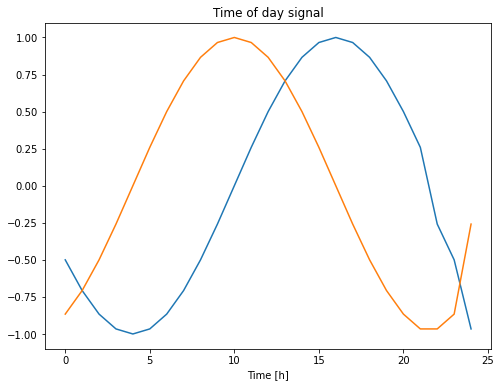

In [14]:
plt.plot(np.array(df['Day sin'])[:25])
plt.plot(np.array(df['Day cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [15]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,288.28,0.0,0.0,40,5545,-0.500000,-8.660254e-01,-0.999682,0.025224
1,289.36,0.0,0.0,75,4516,-0.707107,-7.071068e-01,-0.999663,0.025941
2,289.58,0.0,0.0,90,4767,-0.866025,-5.000000e-01,-0.999645,0.026658
3,290.13,0.0,0.0,90,5026,-0.965926,-2.588190e-01,-0.999625,0.027374
4,291.14,0.0,0.0,75,4918,-1.000000,5.575167e-13,-0.999605,0.028091


### 3.3.4 Visualization of Data:

### 3.3.4.1 Seasonality:

Here is the evolution of a few features over time.

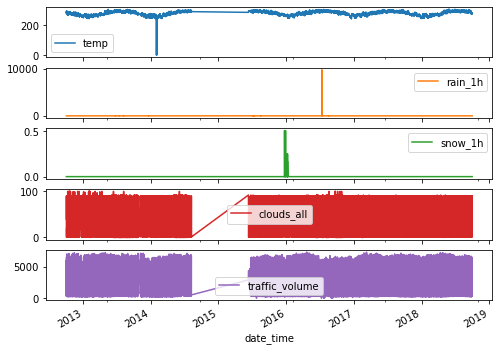

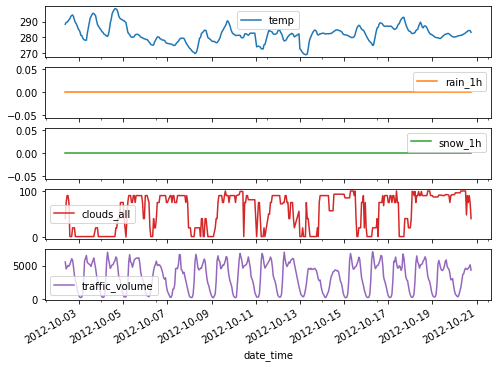

In [16]:
plot_cols = ['temp', 'rain_1h', 'snow_1h', 'clouds_all', 'traffic_volume']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

- In above visualizations, we used different plots to take a look at numerical features over time using raw data.
- We can notice that there are large gaps between the years of 2014 to 2015. These gaps suggest missing traffic volume measurements.
- The shape of the curve for ‘rain_1h’, and ‘snow_1h’ data are same.

In [17]:
df_2 = pd.read_csv('Metro_Interstate_Traffic_Volume.csv', 
                   parse_dates=['date_time'],
                   index_col='date_time')

In [18]:
df_2['hour'] = df_2.index.hour
df_2['day_of_month'] = df_2.index.day
df_2['day_of_week'] = df_2.index.dayofweek
df_2['month'] = df_2.index.month
df_2.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day_of_month,day_of_week,month
date_time,,,,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,9,2,1,10
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,10,2,1,10
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,11,2,1,10
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,12,2,1,10
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,13,2,1,10


#### Traffic Volume by Month:

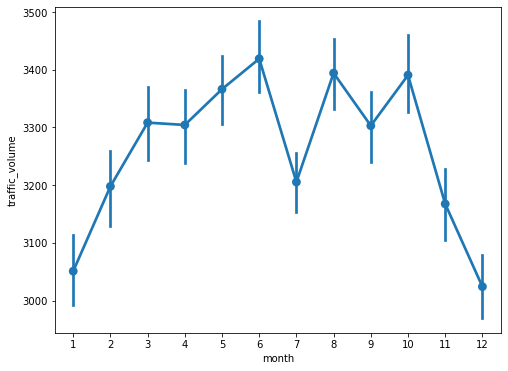

In [19]:
sns.pointplot(data=df_2, x='month', y='traffic_volume')

- The above point plot shows that the data definately have some seasonality component.
- During the spring and summer, the traffic volume is significantly higher compared to other seasons.

#### Traffic Volume by Hour:

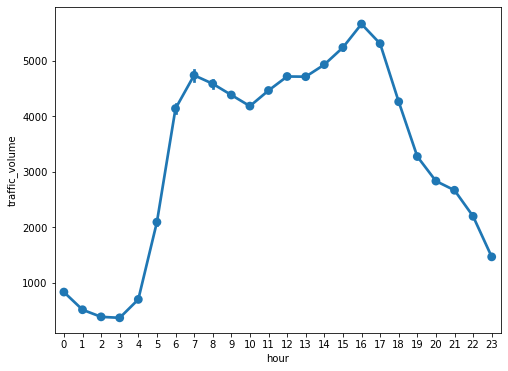

In [20]:
sns.pointplot(data=df_2, x='hour', y='traffic_volume')

- The above point plot shows whether the hour of the day matters when looking at the traffic_volume.
- There is a clear indications that the traffic_volume starting to go up from 4am and it peaks at around 5pm.
- The bussiest hours are between 7am to 5pm then it is starting to decline after 5pm.
- The spike during the morning and evening commute.

#### Traffic Volume by Day of Week:

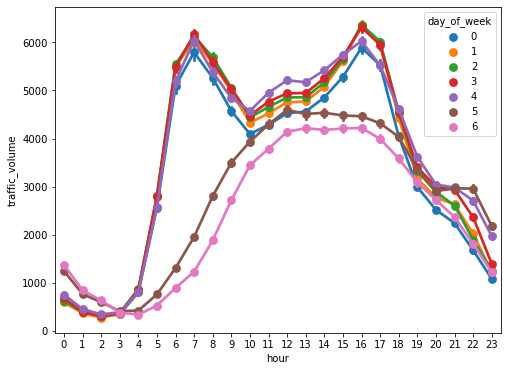

In [21]:
sns.pointplot(data=df_2, x='hour', y='traffic_volume', hue='day_of_week')

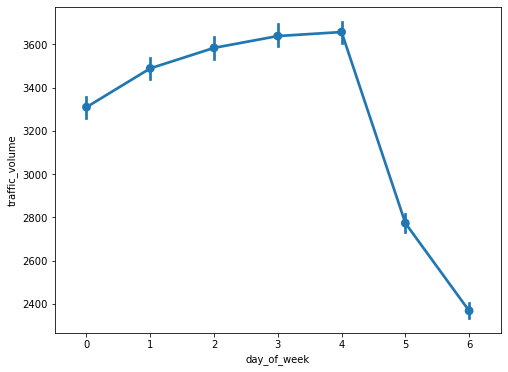

In [22]:
sns.pointplot(data=df_2, x='day_of_week', y='traffic_volume')

- This plots show the trend between weekdays and the weekends.
- We can see that there is some significant spike during the afternoon hours on weekends.
- The overall traffic_volume is also lower during weekends compared to weekdays.
- On weekends, evenings are busier compared to mornings.

### 3.3.4.2 Pairplot:
Let's visualize the attributes using pairplot function from SEABORN package:

A pairplot plots a pairwise relationships in a dataset which shows the Correlation between numerical attributes and it also displays the distributions of all attributes.

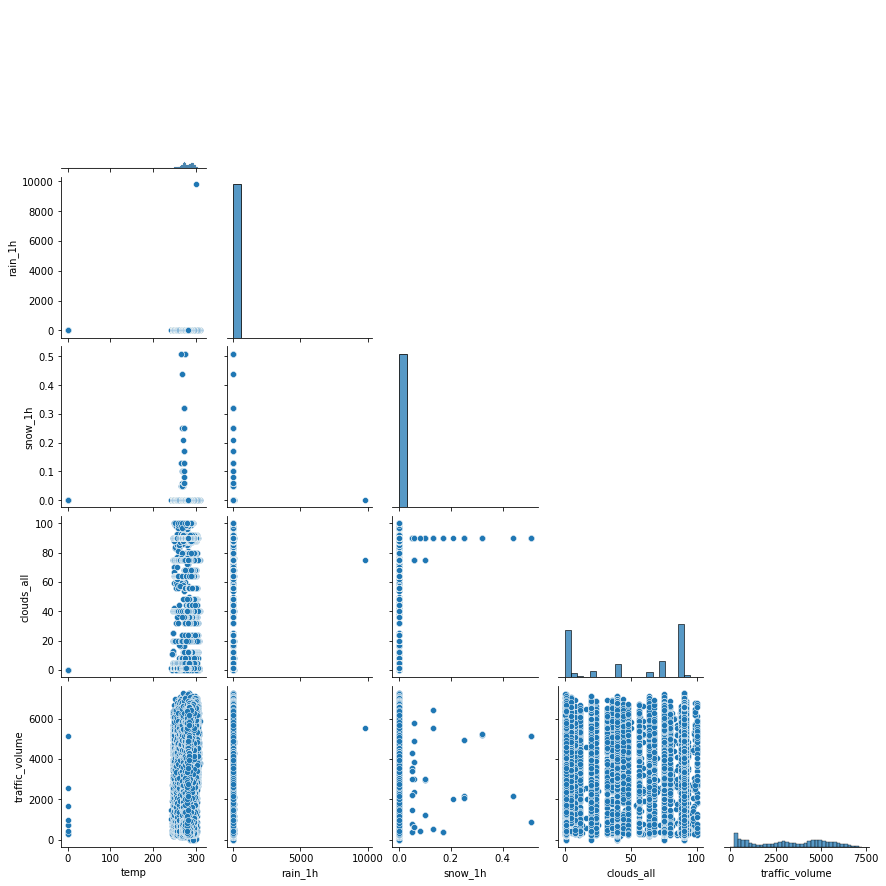

In [23]:
sns.pairplot(df[plot_cols], corner=True)

# 4. Preprocessing:
- Let's prepare the data for model building.

## 4.1 Split the data:
There are 48204 samples in the entire dataset. Let's use the last **5,000** records of the data as the test set. Then we can split the rest of the data into training and validation sets as (**75%, 25%**).

Note the data is not being randomly shuffled before splitting. This is for two reasons.
- It ensures that chopping the data into windows of consecutive samples is still possible.
- It ensures that the validation/test results are more realistic, being evaluated on data collected after the model was trained.

In [24]:
column_indices = {name: i for i, name in enumerate(df.columns)}

test_df = df.tail(5000)
n = len(df) - 5000
train_df = df[0:int(n*0.75)]
val_df = df[int(n*0.75):int(n)]

num_features = df.shape[1]

In [25]:
lst = [len(train_df), len(val_df), len(test_df)]
print('train_df, val_df, test_df:',lst)
print('Total Samples in Entire Dataset:', sum(lst))

train_df, val_df, test_df: [32403, 10801, 5000]
Total Samples in Entire Dataset: 48204


- When we read the data in, it appears in a pandas dataframe. We can use head() and tail() to see the start and end of the different datasets and their subsets.

In [26]:
df.tail()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
48199,283.45,0.0,0.0,75,3543,-7.593937e-12,1.000000,-0.999952,-0.009838
48200,282.76,0.0,0.0,90,2781,2.588190e-01,0.965926,-0.999958,-0.009121
48201,282.73,0.0,0.0,90,2159,5.000000e-01,0.866025,-0.999965,-0.008404
48202,282.09,0.0,0.0,90,1450,7.071068e-01,0.707107,-0.999970,-0.007687
48203,282.12,0.0,0.0,90,954,8.660254e-01,0.500000,-0.999976,-0.006971


In [27]:
test_df.tail()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
48199,283.45,0.0,0.0,75,3543,-7.593937e-12,1.000000,-0.999952,-0.009838
48200,282.76,0.0,0.0,90,2781,2.588190e-01,0.965926,-0.999958,-0.009121
48201,282.73,0.0,0.0,90,2159,5.000000e-01,0.866025,-0.999965,-0.008404
48202,282.09,0.0,0.0,90,1450,7.071068e-01,0.707107,-0.999970,-0.007687
48203,282.12,0.0,0.0,90,954,8.660254e-01,0.500000,-0.999976,-0.006971


In [28]:
df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,288.28,0.0,0.0,40,5545,-0.500000,-8.660254e-01,-0.999682,0.025224
1,289.36,0.0,0.0,75,4516,-0.707107,-7.071068e-01,-0.999663,0.025941
2,289.58,0.0,0.0,90,4767,-0.866025,-5.000000e-01,-0.999645,0.026658
3,290.13,0.0,0.0,90,5026,-0.965926,-2.588190e-01,-0.999625,0.027374
4,291.14,0.0,0.0,75,4918,-1.000000,5.575167e-13,-0.999605,0.028091


In [29]:
train_df.head()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,288.28,0.0,0.0,40,5545,-0.500000,-8.660254e-01,-0.999682,0.025224
1,289.36,0.0,0.0,75,4516,-0.707107,-7.071068e-01,-0.999663,0.025941
2,289.58,0.0,0.0,90,4767,-0.866025,-5.000000e-01,-0.999645,0.026658
3,290.13,0.0,0.0,90,5026,-0.965926,-2.588190e-01,-0.999625,0.027374
4,291.14,0.0,0.0,75,4918,-1.000000,5.575167e-13,-0.999605,0.028091


## 4.2 Normalize the data:
It is important to scale features before training a neural network. Normalization is a common way of doing this scaling. Subtract the mean and divide by the standard deviation of each feature.

The mean and standard deviation should only be computed using the training data so that the models have no access to the values in the validation and test sets.

In [30]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

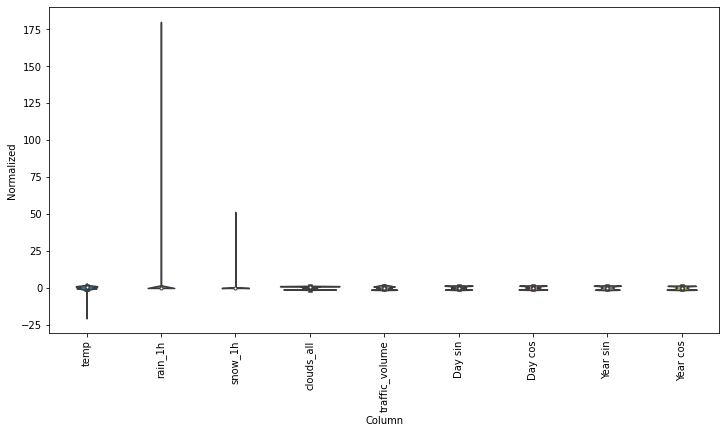

In [31]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

- The above plot is not visualizing information appropriately so let's remove some columns and recreate the violinplot.

In [32]:
df_3 = df.copy()
df_3.pop('temp')
df_3.pop('rain_1h')
df_3.pop('snow_1h')
df_3.head()

,clouds_all,traffic_volume,Day sin,Day cos,Year sin,Year cos
0,40,5545,-0.500000,-8.660254e-01,-0.999682,0.025224
1,75,4516,-0.707107,-7.071068e-01,-0.999663,0.025941
2,90,4767,-0.866025,-5.000000e-01,-0.999645,0.026658
3,90,5026,-0.965926,-2.588190e-01,-0.999625,0.027374
4,75,4918,-1.000000,5.575167e-13,-0.999605,0.028091


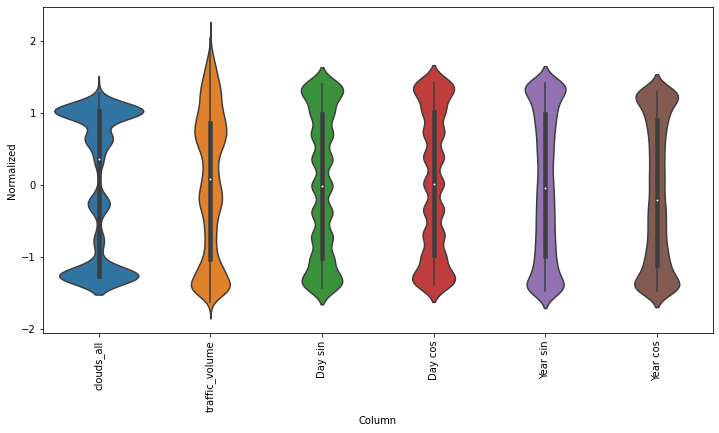

In [33]:
df_3_std = (df_3 - train_mean[df_3.columns]) / train_std[df_3.columns]
df_3_std = df_3_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_3_std)
_ = ax.set_xticklabels(df_3.keys(), rotation=90)

## 4.3 Data windowing:
The models will make a set of predictions based on a window of consecutive samples from the data.

The main features of the input windows are:
- The width (number of time steps) of the input and label windows. 
- The time offset between them. 
- Which features are used as inputs, labels, or both.

The specific goal will be to predict from a **6-hour input window**, only the traffic volume for **2 hours past the end of the window**.

- Single-time-step
- Single Output

That is a little different from the multi-step (and multi-output) RNN with LSTM example.

This section focuses on implementing the data windowing so that it can be reused for all of those models.

### 4.3.1 Indexes and offsets:

The WindowGenerator class can:

- Handle the indexes and offsets as shown in the diagrams above.
- Split windows of features into a (features, labels) pairs.
- Plot the content of the resulting windows.
- Efficiently generate batches of these windows from the training, evaluation, and test data.

In [34]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

### 4.3.2 Split:
Given a list consecutive inputs, the split_window method will convert them to a window of inputs and a window of labels.

In [35]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

### 4.3.3 Plot:
Here is a plot method that allows a simple visualization of the split window:

In [36]:
def plot(self, model=None, plot_col='traffic_volume', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [h]')

WindowGenerator.plot = plot

### 4.3.4 Create tf.data.Datasets:
Finally this **make_dataset** method will take a time series **DataFrame** and convert it to a **tf.data.Dataset** of (**input_window, label_window**) pairs using the **preprocessing.timeseries_dataset_from_array** function.

In [37]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

The **WindowGenerator** object holds training, validation and test data. Add properties for accessing them as **tf.data.Datasets** using the above **make_dataset** method. Also add a standard example batch for easy access and plotting:

In [38]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

Now the **WindowGenerator** object gives you access to the **tf.data.Dataset** objects, so you can easily iterate over the data.

The **Dataset.element_spec** property tells you the structure, dtypes and shapes of the dataset elements.

The specific goal is to predict from a **6-hour input window**, only the traffic volume for **2 hours past the end of the window**.

In [39]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=2,
                     label_columns=['traffic_volume'])
w2

Total window size: 8
Input indices: [0 1 2 3 4 5]
Label indices: [7]
Label column name(s): ['traffic_volume']

This plot aligns inputs, labels, and (later) predictions based on the time that the item refers to:

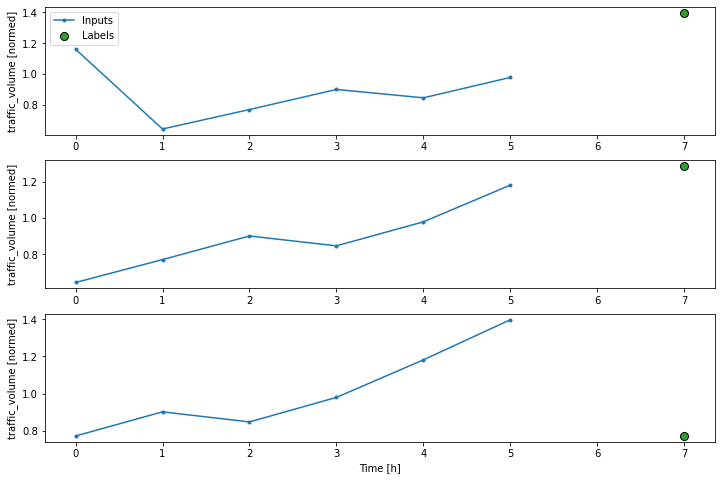

In [40]:
w2.plot()

In [41]:
# Each element is an (inputs, label) pair
w2.train.element_spec

(TensorSpec(shape=(None, 6, 9), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

Iterating over a Dataset yields concrete batches:

In [42]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 9)
Labels shape (batch, time, features): (32, 1, 1)


# 5. Model Building:
After building a baseline model (e.g. an LSTM model), we will search for an optimal model/hyperparameter setting. We are going to experiment with couple of different models and in the experiments, we may try exploring advanced features and architectures such as:
- Batch size
- Number of recurrent units
- Stacking recurrent layers
- Statefulness
- Recurrent dropout
- Bidirectional RNNs

In [43]:
# package the training procedure into a function:
def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

## 5.1 Recurrent neural network:
A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In this project, we will use an RNN layer called Long Short Term Memory (LSTM).

An important constructor argument for all keras RNN layers is the **return_sequences** argument. This setting can configure the layer in one of two ways.

1. If **False**, the default, the layer only returns the output of the final timestep, giving the model time to warm up its internal state before making a single prediction.

2. If **True** the layer returns an output for each input. This is useful for:
    - Stacking RNN layers.
    - Training a model on multiple timesteps simultaneously.

In [44]:
val_performance = {}
performance = {}

### 5.1.1 Baseline Model:
Before building a trainable model it would be good to have a performance baseline as a point for comparison with the later more complicated models.

#### Build the model:

In [45]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, 1])
])

In [46]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', lstm_model(w2.example[0]).shape)

Input shape: (32, 6, 9)
Output shape: (32, 1, 1)


#### Compile and fit the model:

In [47]:
MAX_EPOCHS = 25
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM_b'] = lstm_model.evaluate(w2.val)
performance['LSTM_b'] = lstm_model.evaluate(w2.test, verbose=0)

338/338 [==============================] - 1s 3ms/step - loss: 0.0720 - mean_absolute_error: 0.1881


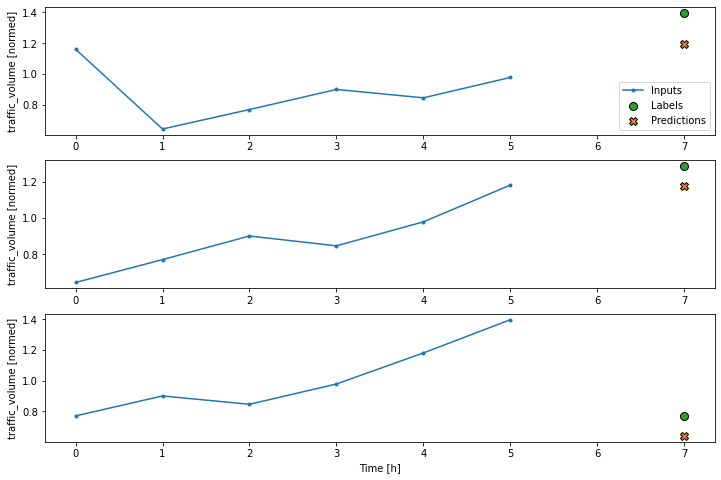

In [48]:
w2.plot(lstm_model)

#### Evaluate the model:

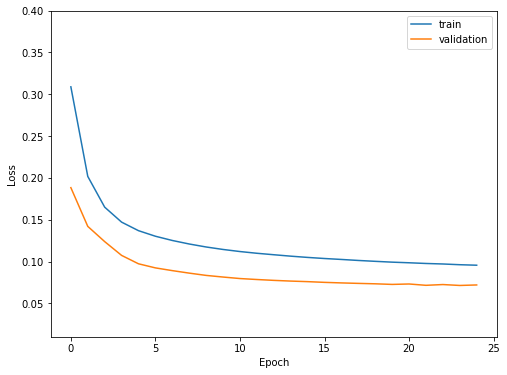

In [49]:
# Evaluate the model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 0.4])
plt.legend()

- In the plots, the blue line represents the training loss, and the orange line shows the validation loss.
- It turns out that the loss decreases faster in the beginning but after 5 epochs it is not dropping quickly. 
- There is a gap between the train and validation loss curves from the beginning, however this gap widens after 5 epochs. This gap between training loss and validation loss represents overfitting. Overfitting happens when a machine learning model performs worse on new, previously unseen inputs than it does on the training data. An overfitted model "memorizes" the noise and details in the training dataset to a point where it negatively impacts the performance of the model on the new data. 
- These curves suggest that the data contains a lot of noise. The model over-optimizes and learns representations specific to the training data that do not generalize to test data.
- The goal of my experiments is not only to decrease the loss but also to prevent/reduce overfitting. The pre-experiment expectations are that the gap between training and testing loss values will narrow down. In achieving this goal, the training and validation loss might go up.

#### Make Predictions:

- There are 48204 samples in the entire dataset and we have used the last 5,000 records of the data as the test set.
- We are going to use the first 6 of those values (with indices 43,204 to 43,209, inclusive) to predict the value for two hours later, i.e., the one in row 43,211.
- And so on, hour-by-hour, until we predict the last row/hour (48203), based on rows 48,196 to 48,201 (inclusive).
- For a total of 4993 lines in .csv submission file after the header line, which will be "id,prediction".
- For the id value of each prediction, we will use integers from 1 to 4993 (MOD).
- We will also denormalize the predictions.
- Then finaly, save them to the aforementioned .csv file with the appropriate indices, e.g., by putting the predictions back into a DataFrame.
- This .csv file will be submitted to Kaggle competition.

In [50]:
preds = lstm_model.predict(w2.test).flatten()
preds_denorm = (preds*train_std[4]) + train_mean[4]
df_preds = pd.DataFrame(preds_denorm, columns=['prediction'])
df_preds.index = np.arange(1, len(df_preds) + 1)
df_preds.to_csv('submission_umair_1.csv', index_label='id')

### 5.1.2 Model 2:

Let us build our second model by keeping same features as base line model and just changing the following features:
- Change number of recurrent units from 32 to 128

#### Build the model:

In [51]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(128, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, 1])
])

In [52]:
print('Input shape:', w2.example[0].shape)
print('Output shape:', lstm_model(w2.example[0]).shape)

Input shape: (32, 6, 9)
Output shape: (32, 1, 1)


#### Compile and fit the model:

In [53]:
MAX_EPOCHS = 25
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM_2'] = lstm_model.evaluate(w2.val)
performance['LSTM_2'] = lstm_model.evaluate(w2.test, verbose=0)

338/338 [==============================] - 2s 5ms/step - loss: 0.0722 - mean_absolute_error: 0.1856


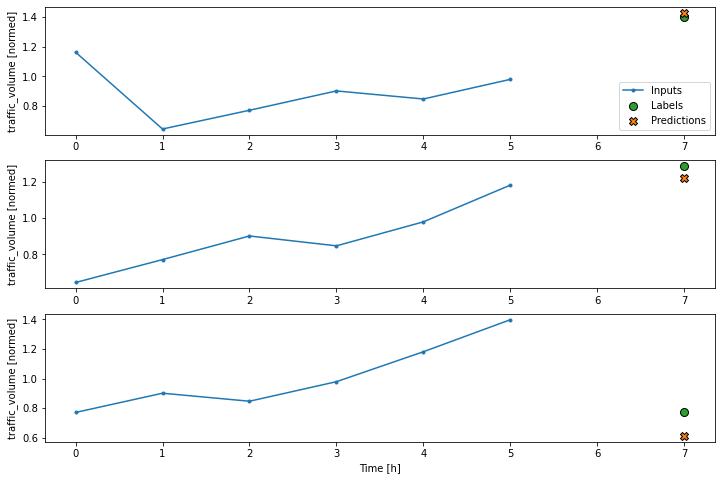

In [54]:
w2.plot(lstm_model)

#### Evaluate the model:

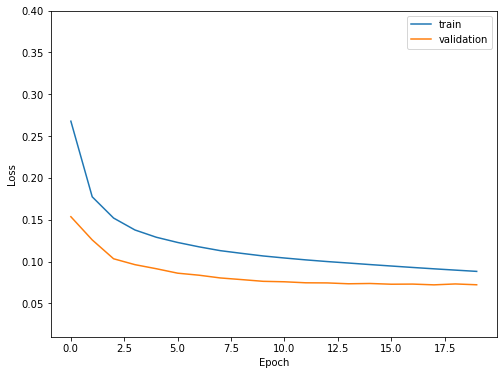

In [55]:
# Evaluate the model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 0.4])
plt.legend()

- After increasing the recurrent units, the model did not produced better results compared to the base model and it also took more time to train.

#### Make Predictions:

In [56]:
preds = lstm_model.predict(w2.test).flatten()
preds_denorm = (preds*train_std[4]) + train_mean[4]
df_preds = pd.DataFrame(preds_denorm, columns=['prediction'])
df_preds.index = np.arange(1, len(df_preds) + 1)
df_preds.to_csv('submission_umair_2.csv', index_label='id')

### 5.1.3 Model 3:

Let us build our third model by keeping same features as base line model and just changing the following features:
- Add dropout layer to tackle overfitting

The complexity of neural networks makes them more prone to overfitting. In this experiment I used dropout technique which makes slight modifications to the learning algorithm to tackle overfitting.

#### Build the model:

In [57]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, time, features]
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, 1])
])

#### Compile and fit the model:

In [58]:
MAX_EPOCHS = 25
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM_3'] = lstm_model.evaluate(w2.val)
performance['LSTM_3'] = lstm_model.evaluate(w2.test, verbose=0)

338/338 [==============================] - 1s 4ms/step - loss: 0.0714 - mean_absolute_error: 0.1892


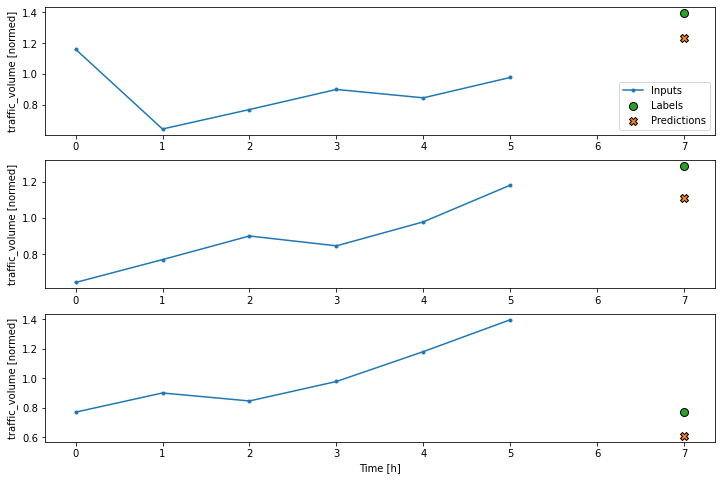

In [59]:
w2.plot(lstm_model)

#### Evaluate the model:

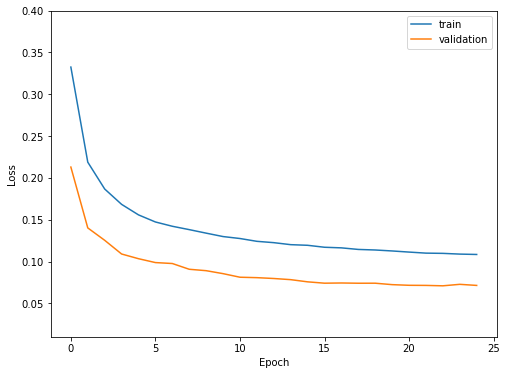

In [60]:
# Evaluate the model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 0.4])
plt.legend()

- After adding the dropout, the model did not improve compared to the base model so let's try something else.

#### Make Predictions:

In [61]:
preds = lstm_model.predict(w2.test).flatten()
preds_denorm = (preds*train_std[4]) + train_mean[4]
df_preds = pd.DataFrame(preds_denorm, columns=['prediction'])
df_preds.index = np.arange(1, len(df_preds) + 1)
df_preds.to_csv('submission_umair_3.csv', index_label='id')

### 5.1.4 Model 4:

Let's build our fourth model by changing the following features:
- Add Bidirectional RNNs
- Add dropout layers to tackle overfitting

#### Build the model:

In [62]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.1),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, 1])
])

#### Compile and fit the model:

In [63]:
MAX_EPOCHS = 25
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM_4'] = lstm_model.evaluate(w2.val)
performance['LSTM_4'] = lstm_model.evaluate(w2.test, verbose=0)

338/338 [==============================] - 1s 4ms/step - loss: 0.0712 - mean_absolute_error: 0.1900


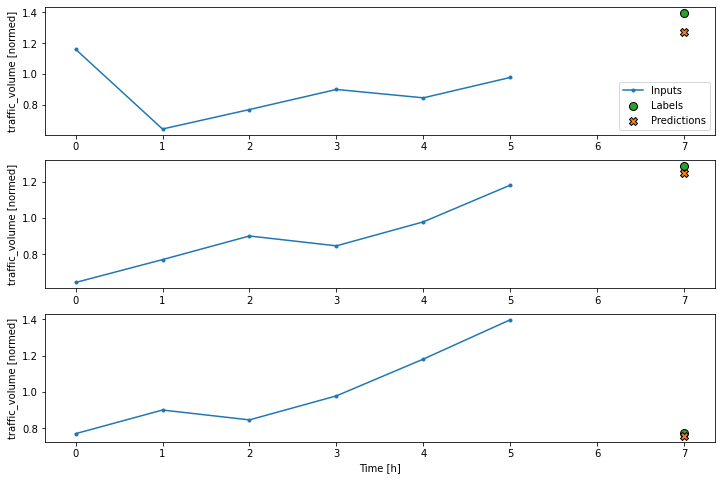

In [64]:
w2.plot(lstm_model)

#### Evaluate the model:

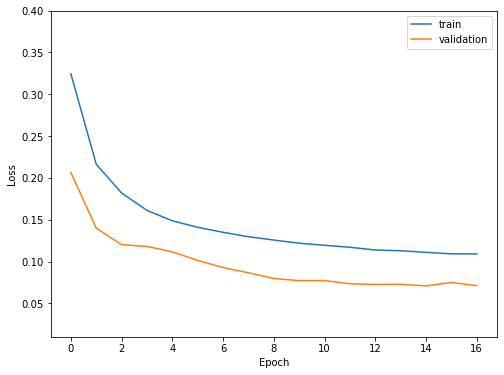

In [65]:
# Evaluate the model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 0.4])
plt.legend()

#### Make Predictions:

In [66]:
preds = lstm_model.predict(w2.test).flatten()
preds_denorm = (preds*train_std[4]) + train_mean[4]
df_preds = pd.DataFrame(preds_denorm, columns=['prediction'])
df_preds.index = np.arange(1, len(df_preds) + 1)
df_preds.to_csv('submission_umair_4.csv', index_label='id')

### 5.1.5 Model 5 - BEST MODEL:

Let's build our FIFTH and final model by changing the following features:
- Add Bidirectional RNNs
- Add dropout layer with 0.10 to tackle overfitting
- Increase number of epochs to 100

#### Build the model:

In [67]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(LSTM(32, return_sequences=False)),
    tf.keras.layers.Dropout(0.10),
    tf.keras.layers.Dense(units=1),
    tf.keras.layers.Reshape([1, 1])
])

#### Compile and fit the model:

In [68]:
MAX_EPOCHS = 100
history = compile_and_fit(lstm_model, w2)

IPython.display.clear_output()
val_performance['LSTM_5'] = lstm_model.evaluate(w2.val)
performance['LSTM_5'] = lstm_model.evaluate(w2.test, verbose=0)

338/338 [==============================] - 2s 4ms/step - loss: 0.0674 - mean_absolute_error: 0.1851


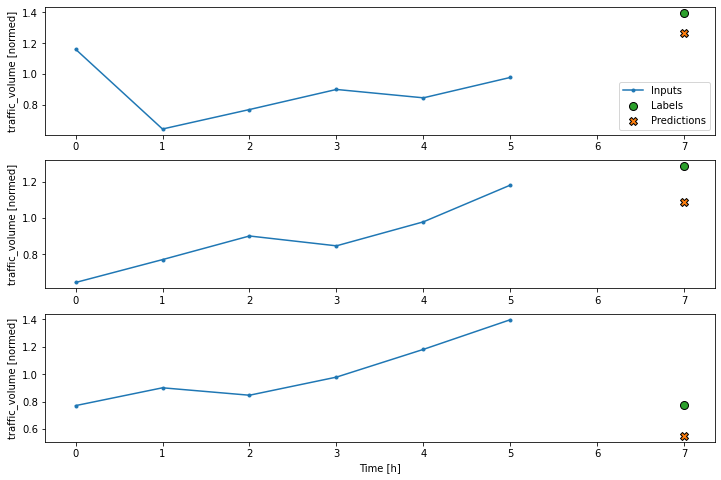

In [69]:
w2.plot(lstm_model)

#### Evaluate the model:

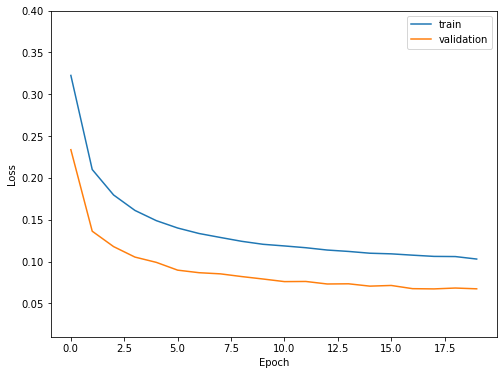

In [70]:
# Evaluate the model
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0.01, 0.4])
plt.legend()

#### Make Predictions:

In [71]:
preds = lstm_model.predict(w2.test).flatten()
preds_denorm = (preds*train_std[4]) + train_mean[4]
df_preds = pd.DataFrame(preds_denorm, columns=['prediction'])
df_preds.index = np.arange(1, len(df_preds) + 1)
df_preds.to_csv('submission_umair_5.csv', index_label='id')

The fifth and the final (BEST) model has one bidirectional LSTM layer with 32 recurrent units. The return_sequences is set to False, and the activation function is ReLU. The dropout layer was added to tackle the overfitting and the number of epochs were increased from 25 to 100. The loss function MAE was used, and the optimizer was set to adam. So far, this model produced the lowest MAE with less overfitting compared to other models. It turns out that the loss decreases faster in the beginning but after 5 epochs it is not dropping quickly. There is a gap between the train and validation loss curves from the beginning, however this gap widens after 5 epochs

## 5.2 Performance:
The below visualization shows the performance metrics of different models. The MAE (mean_absolute_error) of the different models is compared to select the final model for prediction. The model-5 was selected based on its performance. It had the lowest MAE score of around 0.16.

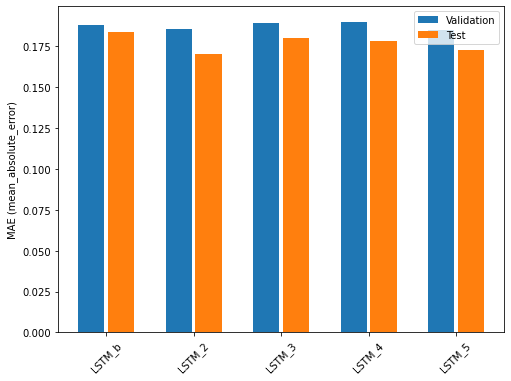

In [72]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (mean_absolute_error)')
_ = plt.legend()

In [73]:
for name, value in performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

LSTM_b  : 0.1837
LSTM_2  : 0.1703
LSTM_3  : 0.1799
LSTM_4  : 0.1783
LSTM_5  : 0.1725
